Este script genera heatmaps de actividad electrica y locomotora durante el estimulo. 

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [44]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.spatial import distance

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = r'D:\datos_GPetersii\datos_GPetersii\Fish1\Object\raw\50fps' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_vid = sorted(glob.glob('*.h5'))
#on_off1 = pd.read_csv(os.path.join(data_folder, 'on_off_trial1.csv'), header=None) #asegurarse de terner los .csv en la misma carpeta que el pkl
#on_off2 = pd.read_csv(os.path.join(data_folder, 'on_off_trial2.csv'), header=None)
files_EOD = sorted(glob.glob('*.bin'))
obj_coordinates = [348.9, 137.8]
#definimos parametros
sf = 50000


In [45]:
#cargamos el archivo de FB-DOE
with open('fish1_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'fish1_FB-DOE.pkl'

A continuacion tenemos algunas celdas que pre-procesan nuestros datos y filtran los archivos para solo utilizar los que contienen registros durante la estimulacion.

In [37]:
# generamos la lista files_start que contiene las timestamps en formato datetime del comienzo de cada uno de los archivos
files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in FB_doe['FB-DOE'].keys()]
print(files_start)# convertimos on_off1 a formato datetime
on_off1[0] = on_off1[0].apply(lambda x: datetime.fromisoformat(x[:-6]))

# ahora pasamos on_off1 a formato dataframe y nos quedamos solo con la columna de tiempo de on 
on_off = pd.DataFrame(np.zeros(shape=(len(on_off1), 2)), columns=['Trial 1', 'Trial 2'])
on_off['Trial 1'] = on_off1.drop(on_off1.columns[[1, 2]], axis=1)

# hacemos lo mismo con on_off2 y lo agregamos al dataframe on_off
on_off2[0] = on_off2[0].apply(lambda x: datetime.fromisoformat(x[:-6]))
on_off['Trial 2'] = on_off2.drop(on_off2.columns[[1, 2]], axis=1)

[datetime.datetime(2024, 1, 16, 17, 2, 51), datetime.datetime(2024, 1, 16, 17, 22, 51), datetime.datetime(2024, 1, 16, 17, 42, 51), datetime.datetime(2024, 1, 16, 18, 2, 51), datetime.datetime(2024, 1, 16, 18, 22, 51), datetime.datetime(2024, 1, 16, 18, 42, 52), datetime.datetime(2024, 1, 16, 19, 2, 52), datetime.datetime(2024, 1, 16, 19, 22, 52), datetime.datetime(2024, 1, 16, 19, 42, 52), datetime.datetime(2024, 1, 16, 20, 2, 52), datetime.datetime(2024, 1, 16, 20, 22, 52), datetime.datetime(2024, 1, 16, 20, 42, 52), datetime.datetime(2024, 1, 16, 21, 2, 53), datetime.datetime(2024, 1, 16, 21, 22, 53), datetime.datetime(2024, 1, 16, 21, 42, 53), datetime.datetime(2024, 1, 16, 22, 2, 53), datetime.datetime(2024, 1, 16, 22, 22, 53), datetime.datetime(2024, 1, 16, 22, 42, 53), datetime.datetime(2024, 1, 16, 23, 2, 53), datetime.datetime(2024, 1, 16, 23, 22, 54), datetime.datetime(2024, 1, 16, 23, 42, 54), datetime.datetime(2024, 1, 17, 0, 2, 54), datetime.datetime(2024, 1, 17, 0, 22, 54

In [38]:
# guardamos algunos tiempos de referencia para filtrar los archivos 
trial1_last = on_off['Trial 1'].iloc[-1]
trial2_last = on_off['Trial 2'].iloc[-1]
trial2_first = on_off['Trial 2'].iloc[0]

# generamos n_trial1 y n_trial2 que contiene los indices de los archivos que nos interesan para cada trial
n_trial1 = [i for i, start in enumerate(files_start) if (start - trial1_last).total_seconds() < 0]
n_trial2 = [i for i, start in enumerate(files_start) if (start - trial2_last).total_seconds() < 0 and (start - trial2_first).total_seconds() > 0]

# Achatamos on_off y lo ordenamos
on_off = pd.DataFrame(on_off.values.flatten(), columns=['On_off']).sort_values(by='On_off')
on_off.reset_index(inplace=True)


In [39]:
files_start = [files_start[x] for x in n_trial1 + n_trial2] #nos quedamos solo con los timestamps de los archivos de interes

FB_DOE = FB_doe['FB-DOE'] #guardamos las frequencias en una variable
Peak_time = FB_doe['Peak-time'] # guardamos los peak-times en otra variable

keys1 = [list(FB_DOE.keys())[i] for i in n_trial1] #guardamos las keys del trial 1
keys2 = [list(FB_DOE.keys())[i] for i in n_trial2] #guardamos las keys del trial 2

FB_DOE_T1 = {key: FB_DOE.get(key) for key in keys1} # guardamos las frecuencias del trial 1 
Peaks_T1 = {key: Peak_time.get(key) for key in keys1}  #guardamos los peak-times del trial 1
FB_DOE_T2 = {key: FB_DOE.get(key) for key in keys2}  #guardamos las frecuencias del trial 2
Peaks_T2 = {key: Peak_time.get(key) for key in keys2} #guardamos los peak-times del trial 2

n_files = len(FB_DOE_T1) + len(FB_DOE_T2) #guardamos el numero de files con el que estamos trabajando para usar despues

In [40]:
#inicializamos las listas
EOD_peaks_on = {'Trial 1': [], 'Trial 2': []}
time_EOD_all  = {'Trial 1': [], 'Trial 2': []}
time_obj_all = {'Trial 1': [], 'Trial 2': []}
EOD_f_on = {'Trial 1': [], 'Trial 2': []}
distancia = {'Trial 1': [], 'Trial 2': [], 'Trial 2T' : [], 'Trial 1T': []}

In [41]:
freq_grid = np.zeros(shape=(53,46), dtype=float)
medians = {'Trial 1': {}, 'Trial 2': {}}
time_grid =  np.zeros(shape=(53,46))

In [42]:
for key in list(FB_doe.keys()): #loopeamos entre los archivos de interes
    iterable = keys1 if key == 'Trial 1' else keys2
    for k, file in enumerate(iterable):
        freq = np.array(FB_DOE_T1[file]) if key == 'Trial 1' else FB_DOE_T2[file]
        freqT = Peaks_T1[file] if key == 'Trial 1' else Peaks_T2[file]

        midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
        start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
        EOD = np.fromfile(files_EOD[k],dtype=np.int16)
        time_EOD = np.linspace(start=start, stop=start+len(EOD)/sf, num=len(EOD))
        del EOD
        freqT = time_EOD[freqT]
        vid = pd.read_hdf(files_vid[k])
        durationVideo = len(vid)/50 
        videoTime = np.linspace(start=start, stop=start+durationVideo, num=round(durationVideo*50))
    
        #Get de median fish position for each frame
        bodyparts = np.array([x for x in vid.columns.get_level_values(1)])
        xpositions = pd.DataFrame(np.zeros((len(vid),5)), columns=np.unique(bodyparts))
        for i in range(5):
            xpositions[np.unique(bodyparts)[i]] = (vid[vid.columns.get_level_values(0)[0], np.unique(bodyparts)[i], 'x'])
        median_xposition = np.median(xpositions, axis=1)
        ypositions = pd.DataFrame(np.zeros((len(vid),5)), columns=np.unique(bodyparts))
        for i in range(5):
            ypositions[np.unique(bodyparts)[i]] = (vid[vid.columns.get_level_values(0)[0], np.unique(bodyparts)[i], 'y'])
        median_yposition = np.median(ypositions, axis=1)
    
        coords = pd.DataFrame([(round(x/10),round(y/10)) for x,y in zip(median_xposition, median_yposition)], columns=['posx', 'posy'])
        grouped_coords = coords.groupby(['posx', 'posy'])
        timeDensity_count =  grouped_coords.size()
        for coord, count in timeDensity_count.items():
            time_grid[coord] += count
        f_video = []
        for i in range(len(videoTime)-1):
            dif = abs(freqT - videoTime[i])
            closest = np.min(dif)
            index = dif.tolist().index(closest)
            fi = freq[index-1]
            f_video.append(fi)
        
        if len(f_video) != len(coords):
            for i in range(abs(len(f_video)-len(coords))):
                f_video.append(np.nan)

        coords['f_vid'] = f_video
        grouped_coords = coords.groupby(['posx', 'posy']).median().reset_index()
        
        for i in range(len(grouped_coords)):
            freq_grid[grouped_coords.iloc[i,0], grouped_coords.iloc[i,1]] += grouped_coords.iloc[i,2]
         
        print('termino archivo ' + str(k))

termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11
termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11


In [29]:
def plot_map(grid, objCoordinates,cmap, label,filename, vmax=None,vmin=None):
    fig, ax = plt.subplots()
    plt.imshow(grid, cmap=cmap, vmax=vmax, vmin=vmin, origin='lower')
    cbar = plt.colorbar()
    cbar.set_label(label)
    plt.scatter(objCoordinates[1]/10, objCoordinates[0]/10, s=100, c='k')
    fig.savefig(filename, format='svg', dpi=1200)


In [30]:
time_grid[time_grid == 0 ] = np.nan
freq_grid[freq_grid == 0 ] = np.nan
time_grid = time_grid/50 #convert to seconds
freq_grid = freq_grid/24 #divide by the number of files to give the mean

In [31]:
time_grid = time_grid/288 #divido por segundos totales *100 para obtener el %

In [32]:
SD_grid = time_grid * freq_grid

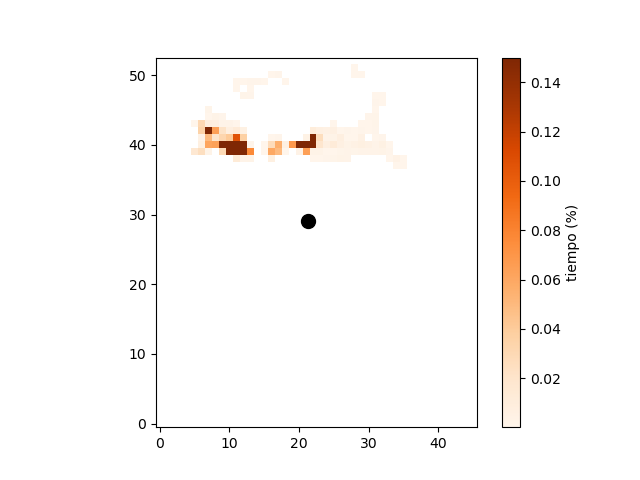

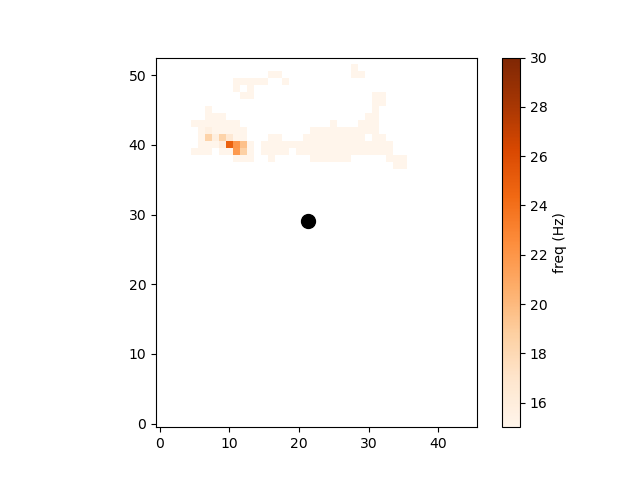

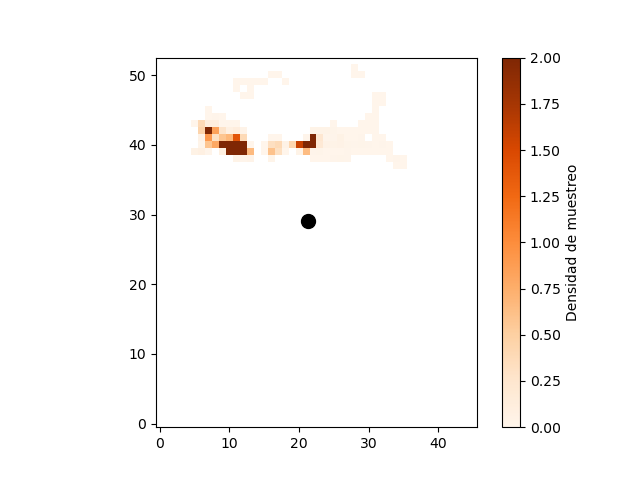

In [34]:
%matplotlib widget
import seaborn as sns
#palette = sns.color_palette("ch:s=0.9,r=-0.55", as_cmap=True)
plot_map(time_grid, obj_coordinates, 'Oranges', vmax=.15, filename='time_grid_P2.svg',label='tiempo (%)')
plot_map(freq_grid, obj_coordinates, 'Oranges', vmax=30, vmin=15,filename='freq_grid_P2.svg',label='freq (Hz)')
plot_map(SD_grid, obj_coordinates, 'Oranges', vmax=2, vmin=0,filename='SD_grid_P2.svg',label='Densidad de muestreo')

In [16]:
SD_by_distance = np.zeros(shape=(53*46, 4))
for i, x in enumerate(SD_grid):
    for j, y in enumerate(x):
        SD_by_distance[j+46*i, 0] = i
        SD_by_distance[j+46*i, 1] = j
        SD_by_distance[j+46*i, 2] = y
    
print(SD_by_distance)

[[ 0.  0. nan  0.]
 [ 0.  1. nan  0.]
 [ 0.  2. nan  0.]
 ...
 [52. 43. nan  0.]
 [52. 44. nan  0.]
 [52. 45. nan  0.]]


In [17]:
i=0
for x, y in zip(SD_by_distance[:,0], SD_by_distance[:,1]):
    
    SD_by_distance[i, 3] = round(distance.euclidean([x,y], [j/10 for j in obj_coordinates]))
    i+=1

SD_by_distance

array([[ 0.,  0., nan, 36.],
       [ 0.,  1., nan, 35.],
       [ 0.,  2., nan, 35.],
       ...,
       [52., 43., nan, 32.],
       [52., 44., nan, 32.],
       [52., 45., nan, 33.]])

In [18]:
SD_by_distance = pd.DataFrame(SD_by_distance[:,2:], columns=['SD', 'distance'])
SD_by_distance_grouped = SD_by_distance.groupby('distance')


In [19]:
mean_SD_distance = np.zeros(shape=(len(SD_by_distance_grouped), 2))
i=0
for name, group in SD_by_distance_grouped:
    mean_SD_distance[i, 0] = int(name)
    mean_SD_distance[i,1] = np.nanmedian(group['SD'])
    i+=1
np.savetxt(fname='mean_SD_distance.txt', X=mean_SD_distance)

c:\Users\Compras\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


In [20]:
m = np.loadtxt('mean_SD_distance.txt')
m[:,0] = m[:,0].astype(int)

In [21]:
m

array([[0.00000000e+00,            nan],
       [1.00000000e+00,            nan],
       [2.00000000e+00,            nan],
       [3.00000000e+00, 4.46875410e-04],
       [4.00000000e+00, 1.68646530e-01],
       [5.00000000e+00, 1.56430274e-02],
       [6.00000000e+00, 5.20335462e-02],
       [7.00000000e+00, 3.14510235e-03],
       [8.00000000e+00, 1.88194742e-03],
       [9.00000000e+00, 9.47661555e-02],
       [1.00000000e+01, 1.25553764e-02],
       [1.10000000e+01, 7.42682145e-03],
       [1.20000000e+01, 3.29455377e-03],
       [1.30000000e+01, 1.15707297e-02],
       [1.40000000e+01, 4.93680844e-03],
       [1.50000000e+01, 3.17263211e-03],
       [1.60000000e+01, 2.15131470e-03],
       [1.70000000e+01, 5.51863460e-03],
       [1.80000000e+01, 3.85002143e-03],
       [1.90000000e+01, 3.48613755e-03],
       [2.00000000e+01, 3.32585536e-03],
       [2.10000000e+01, 4.50156522e-03],
       [2.20000000e+01, 2.50521063e-03],
       [2.30000000e+01, 2.48014527e-03],
       [2.400000

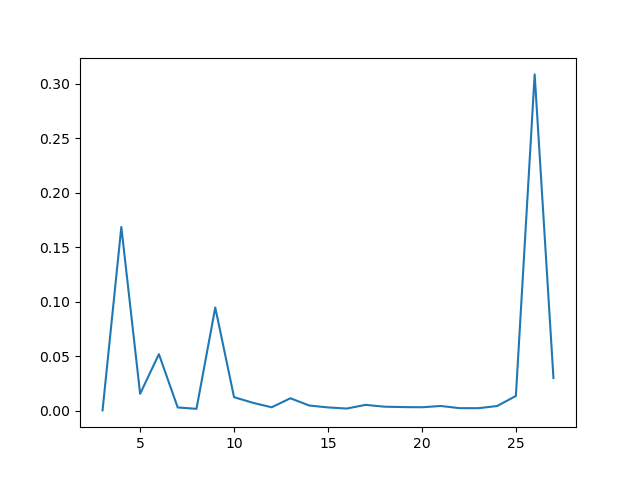

In [22]:
plt.figure()
plt.plot(mean_SD_distance[:,1])
plt.show()